In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
#Parameters


#MACD parameters
n = 9
m = 19
t = 6

#RSI parameters
period = 14

In [20]:
dataimport = pd.read_csv('/Users/vedantgupta/Documents/project /summer project(finance)/Pair-Trading--ML-TI-/data/Sensex.csv')


dataimport['Date'] = pd.to_datetime(dataimport['Date'])
dataimport.set_index('Date', inplace=True)
data = dataimport.resample('W').first()  # Weekly Resampling

data.reset_index(inplace=True)
data['Date'] = data['Date'].astype(str)
stock_names = data.columns[1:]

datacopy = data.copy()

data

,Date,KMB IB Equity,HCLT IB Equity,NTPC IB Equity,NEST IB Equity,BHARTI IB Equity,RELIANCE IB Equity,TCS IB Equity,ITC IB Equity,MM IB Equity,...,HDFCB IB Equity,ICICIBC IB Equity,APNT IB Equity,SBIN IB Equity,TTAN IB Equity,TTMT IB Equity,IIB IB Equity,JSTL IB Equity,LT IB Equity,AXSB IB Equity
0,2011-01-09,227.88,113.63,165.04,3829.15,323.87,475.67,579.78,116.23,393.53,...,239.05,207.93,287.49,282.09,184.12,258.52,264.80,119.17,879.84,273.52
1,2011-01-16,206.73,116.06,159.17,3785.80,305.39,465.25,564.25,113.67,364.60,...,215.49,184.42,267.46,254.78,164.55,233.15,223.40,98.76,792.20,251.24
2,2011-01-23,201.58,118.85,155.83,3674.65,313.28,450.24,569.08,114.50,368.70,...,207.53,181.95,266.36,251.64,171.48,233.54,227.00,97.55,747.18,245.51
3,2011-01-30,207.55,126.89,160.29,3681.50,300.88,438.17,602.90,112.63,394.10,...,214.83,197.07,262.23,269.31,178.82,235.08,238.60,103.40,738.91,264.42
4,2011-02-06,192.25,123.45,157.42,3326.10,287.10,414.80,578.58,108.63,356.03,...,204.29,185.45,256.93,264.11,179.65,227.21,223.60,90.59,729.40,249.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,2022-12-04,1928.60,1119.00,170.30,19821.00,837.45,2467.10,3397.40,339.95,1250.70,...,1599.75,936.45,3151.80,608.70,2590.85,433.20,1197.95,715.40,2064.10,891.40
622,2022-12-11,1938.45,1131.15,175.00,19761.60,843.90,2444.15,3425.00,336.65,1258.50,...,1612.30,933.55,3157.55,617.15,2615.95,428.70,1194.70,756.55,2085.45,899.30
623,2022-12-18,1865.90,1028.30,168.90,20482.35,827.90,2379.83,3284.50,343.05,1263.65,...,1643.55,929.30,3164.75,613.05,2583.00,414.10,1205.75,740.45,2161.95,938.85
624,2022-12-25,1858.65,1033.25,171.45,20086.65,839.80,2368.67,3201.60,340.40,1290.40,...,1644.50,906.20,3081.05,604.95,2521.30,417.90,1222.65,749.30,2184.10,946.20


In [21]:
data.dtypes

Date                   object
KMB IB Equity         float64
HCLT IB Equity        float64
NTPC IB Equity        float64
NEST IB Equity        float64
BHARTI IB Equity      float64
RELIANCE IB Equity    float64
TCS IB Equity         float64
ITC IB Equity         float64
MM IB Equity          float64
UTCEM IB Equity       float64
TATA IB Equity        float64
SUNP IB Equity        float64
WPRO IB Equity        float64
HUVR IB Equity        float64
INFO IB Equity        float64
MSIL IB Equity        float64
BAF IB Equity         float64
HDFCB IB Equity       float64
ICICIBC IB Equity     float64
APNT IB Equity        float64
SBIN IB Equity        float64
TTAN IB Equity        float64
TTMT IB Equity        float64
IIB IB Equity         float64
JSTL IB Equity        float64
LT IB Equity          float64
AXSB IB Equity        float64
dtype: object

## Strat-1 MACD + RSI

In [22]:
def MACD(price_data, short_window, long_window, signal_window, column_name):
    data = price_data
   
    data.loc[:,'EMAn'] = data[column_name].ewm(span=short_window, adjust=False).mean()
    data.loc[:,'EMAm'] = data[column_name].ewm(span=long_window, adjust=False).mean()

    for i in range(short_window):
        data.loc[i,'EMAn'] = None
    for i in range(long_window):
        data.loc[i,'EMAm'] = None
    
    data['MACD'] = data['EMAn'] - data['EMAm']
    data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    trade_sig=np.zeros([len(data),1],dtype=float)

    for i in range(long_window+1,len(data)):
        if data.loc[i,'MACD'] > data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] < data.loc[i-1,'Signal Line']:
            trade_sig[i] = 1
        if data.loc[i,'MACD'] < data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] > data.loc[i-1,'Signal Line']:
            trade_sig[i] = -1
        
    trade_sig=trade_sig.reshape(len(trade_sig),1)

    data_numpy=data['Date'].to_numpy()
    data_numpy=data_numpy.reshape(len(data_numpy),1)
    data_numpy=np.column_stack((data_numpy,data[column_name].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAn'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAm'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['MACD'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['Signal Line'].to_numpy()))

    final=np.column_stack((data_numpy,trade_sig))
    final_df=pd.DataFrame(final,columns=['Date','Close','EMAn','EMAm','MACD','Signal Line','Trade Signal'],index=data.index)

    final_df.drop(["EMAn","EMAm","MACD","Signal Line"],axis=1,inplace=True)
    final_df['Date'] = pd.to_datetime(final_df['Date'])
    final_df['Close'] = final_df['Close'].astype(float) 
    final_df['Trade Signal'] = final_df['Trade Signal'].astype(int)

    return final_df


master_macd = pd.DataFrame()

for name in stock_names:
    temp = MACD(data, n, m, t, name)
    temp = temp[['Date','Trade Signal']]
    temp.columns = ['Date',name]
    temp.set_index('Date', inplace=True)
    master_macd = pd.concat([master_macd, temp], axis=1)

In [23]:
master_macd.insert(0, 'Date', master_macd.index)
master_macd.reset_index(drop=True, inplace=True)
master_macd = master_macd[period:]
master_macd = master_macd.reset_index(drop=True)
#master_macd = master_macd[232:725]
master_macd

,Date,KMB IB Equity,HCLT IB Equity,NTPC IB Equity,NEST IB Equity,BHARTI IB Equity,RELIANCE IB Equity,TCS IB Equity,ITC IB Equity,MM IB Equity,...,HDFCB IB Equity,ICICIBC IB Equity,APNT IB Equity,SBIN IB Equity,TTAN IB Equity,TTMT IB Equity,IIB IB Equity,JSTL IB Equity,LT IB Equity,AXSB IB Equity
0,2011-04-17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2011-04-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011-05-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011-05-08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2011-05-15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2022-12-04,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608,2022-12-11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
609,2022-12-18,-1,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
610,2022-12-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
def calculate_rsi(prices, period):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def generate_signals(rsi_values):
    signals = np.zeros(rsi_values.shape)
    for rsi in rsi_values:
        if rsi < 30:
            signals[rsi_values == rsi] = 1
        elif rsi > 70:
            signals[rsi_values == rsi] = -1
    return signals

rsi_values = pd.DataFrame()
rsi_values['Date'] = data['Date']
for stock in stock_names:
    rsi_values[stock] = calculate_rsi(data[stock], period)

master_rsi = rsi_values[period:]

In [25]:
#master_rsi = master_rsi[232:725]
master_rsi = master_rsi.reset_index(drop=True)
master_rsi

,Date,KMB IB Equity,HCLT IB Equity,NTPC IB Equity,NEST IB Equity,BHARTI IB Equity,RELIANCE IB Equity,TCS IB Equity,ITC IB Equity,MM IB Equity,...,HDFCB IB Equity,ICICIBC IB Equity,APNT IB Equity,SBIN IB Equity,TTAN IB Equity,TTMT IB Equity,IIB IB Equity,JSTL IB Equity,LT IB Equity,AXSB IB Equity
0,2011-04-17,53.102153,60.118376,46.011035,50.715392,60.182924,49.148798,55.798052,66.937096,47.900292,...,52.112628,52.883589,38.701865,54.532458,59.622868,49.624917,64.156394,41.284187,42.369452,59.508811
1,2011-04-24,55.284720,49.068621,47.071689,51.905733,62.867635,49.773069,50.718010,70.918094,49.788787,...,53.225630,50.526757,39.950937,52.154000,62.721307,48.287204,64.309206,39.179018,43.993689,57.152912
2,2011-05-01,60.382783,63.368919,49.441211,60.790209,66.020365,49.541899,57.599018,71.075776,56.582851,...,57.297171,54.607951,50.361157,63.152744,68.371942,52.555070,64.816888,45.544704,48.084416,54.777140
3,2011-05-08,44.792554,64.452190,43.944761,62.751439,69.151702,40.987120,51.285203,71.930398,52.179121,...,50.910236,52.364723,57.886990,47.174504,59.553568,50.702942,49.721931,40.511292,39.422172,43.584483
4,2011-05-15,48.114017,56.845780,36.957002,69.084256,56.376808,39.923347,47.804474,59.981961,47.429604,...,50.275580,50.036807,57.294333,43.616527,60.415357,44.741780,50.095120,37.298951,36.134483,40.162846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2022-12-04,57.106245,65.317068,58.800267,56.216953,64.517054,60.559422,56.613406,64.867353,56.242764,...,63.878329,65.232986,49.225488,65.453231,54.105080,51.598677,63.043389,58.822339,66.267757,63.787644
608,2022-12-11,57.966865,66.567943,61.948532,55.577478,65.399820,58.785640,57.750116,62.365220,56.933881,...,64.873899,64.557136,49.523933,66.751617,55.377874,50.240091,62.580029,63.611055,67.465877,64.546392
609,2022-12-18,50.008137,50.096881,55.970569,61.326030,61.324120,54.010917,50.497188,65.171133,57.412163,...,67.291349,63.518511,49.920873,65.465964,53.288606,46.007536,63.560676,60.639696,71.387446,68.144907
610,2022-12-25,49.279989,50.728762,57.803692,56.967421,63.162872,53.203460,46.765152,63.074188,59.903087,...,67.364880,58.051663,45.446641,62.888917,49.521029,47.253096,65.068450,61.698796,72.423902,68.779118


In [26]:
prices = datacopy
prices = prices[period:]
prices = prices.reset_index(drop=True)
prices

,Date,KMB IB Equity,HCLT IB Equity,NTPC IB Equity,NEST IB Equity,BHARTI IB Equity,RELIANCE IB Equity,TCS IB Equity,ITC IB Equity,MM IB Equity,...,HDFCB IB Equity,ICICIBC IB Equity,APNT IB Equity,SBIN IB Equity,TTAN IB Equity,TTMT IB Equity,IIB IB Equity,JSTL IB Equity,LT IB Equity,AXSB IB Equity
0,2011-04-17,221.23,122.45,153.17,3709.35,326.08,454.46,589.35,123.30,355.03,...,229.63,199.76,256.73,277.91,189.96,241.26,274.30,95.55,739.29,282.43
1,2011-04-24,224.93,115.96,153.96,3729.80,331.48,455.82,574.85,126.63,360.78,...,231.57,196.76,257.61,275.29,194.84,239.03,274.65,93.53,746.47,278.96
2,2011-05-01,234.43,128.76,155.71,3907.95,338.38,455.34,598.85,126.77,383.83,...,238.96,202.38,266.02,291.94,205.39,245.94,275.75,97.83,765.11,275.43
3,2011-05-08,207.50,130.05,151.17,3955.10,346.04,435.31,579.20,127.50,370.48,...,229.07,199.67,274.07,269.16,195.82,243.10,253.95,93.09,713.04,255.18
4,2011-05-15,213.70,124.63,144.00,4134.40,328.55,432.44,567.08,122.93,354.53,...,228.03,196.82,273.56,262.34,197.32,233.13,254.60,89.66,688.62,247.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2022-12-04,1928.60,1119.00,170.30,19821.00,837.45,2467.10,3397.40,339.95,1250.70,...,1599.75,936.45,3151.80,608.70,2590.85,433.20,1197.95,715.40,2064.10,891.40
608,2022-12-11,1938.45,1131.15,175.00,19761.60,843.90,2444.15,3425.00,336.65,1258.50,...,1612.30,933.55,3157.55,617.15,2615.95,428.70,1194.70,756.55,2085.45,899.30
609,2022-12-18,1865.90,1028.30,168.90,20482.35,827.90,2379.83,3284.50,343.05,1263.65,...,1643.55,929.30,3164.75,613.05,2583.00,414.10,1205.75,740.45,2161.95,938.85
610,2022-12-25,1858.65,1033.25,171.45,20086.65,839.80,2368.67,3201.60,340.40,1290.40,...,1644.50,906.20,3081.05,604.95,2521.30,417.90,1222.65,749.30,2184.10,946.20


In [27]:
def get_returns(master_macd, master_rsi, prices):
    returns = []
    intrade = []
    tradesheet = pd.DataFrame(columns=['Date','Buy Stock','Sell Stock','Buy Price','Sell Price','Buy Quantity','Sell Quantity','Profit'])
    i = 0
    while(i<len(prices)) :
        buy = 0
        buy_rsi = 100.0
        sell = 0
        sell_rsi = 0.0
        for j in range(1,len(prices.columns)):
            if(master_macd.iloc[i,j]==1):
                if(master_rsi.iloc[i,j]<buy_rsi):
                    buy = j
                    buy_rsi = master_rsi.iloc[i,j]
            elif(master_macd.iloc[i,j]==-1):
                if(master_rsi.iloc[i,j]>sell_rsi):
                    sell = j
                    sell_rsi = master_rsi.iloc[i,j]

        if(len(intrade)==0) :
            returns.append(0)
            
        else :
            b1 = prices.iloc[intrade[0][0],intrade[0][1]]
            s1 = prices.iloc[intrade[0][0],intrade[0][3]]
            b2 = prices.iloc[i,intrade[0][1]]
            s2 = prices.iloc[i,intrade[0][3]]
            r = (((b2-b1))*intrade[0][2]) + ((s1-s2))
            row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[intrade[0][3]],'Sell Stock':prices.columns[intrade[0][1]],'Buy Price':s2,'Sell Price':b2,'Buy Quantity':1,'Sell Quantity':intrade[0][2],'Profit':r},index=[0])
            tradesheet = pd.concat([tradesheet,row],ignore_index=True)
            returns.append(r)
            intrade.clear()

        
        if(buy!=0 and sell!=0) :
            buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
            l = [i,buy,buy_quantity,sell]
            row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[buy],'Sell Stock':prices.columns[sell],'Buy Price':prices.iloc[i,buy],'Sell Price':prices.iloc[i,sell],'Buy Quantity':buy_quantity,'Sell Quantity':float(1),'Profit':0},index=[0])
            tradesheet = pd.concat([tradesheet,row],ignore_index=True)
            intrade.append(l)
        
        i = i+1

    return returns, intrade, tradesheet

    

In [28]:
returns,intrade, tradesheet = get_returns(master_macd, master_rsi, prices)

/var/folders/90/5g2l2f2j191dmr85qjr8jrn40000gn/T/ipykernel_42146/1179191895.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tradesheet = pd.concat([tradesheet,row],ignore_index=True)


In [29]:
tradesheet.to_csv('/Users/vedantgupta/Documents/project /summer project(finance)/Pair-Trading--ML-TI-/tradesheets/Sensex/Without Clustering/Weekly MACD+RSI Sensex.csv',index=False)
tradesheet


,Date,Buy Stock,Sell Stock,Buy Price,Sell Price,Buy Quantity,Sell Quantity,Profit
0,2011-06-05,HDFCB IB Equity,ITC IB Equity,230.83,125.07,0.541827,1.000000,0
1,2011-06-12,ITC IB Equity,HDFCB IB Equity,128.47,237.55,1.000000,0.541827,0.24108
2,2011-06-19,INFO IB Equity,HCLT IB Equity,359.69,125.26,0.348244,1.000000,0
3,2011-06-26,HCLT IB Equity,INFO IB Equity,116.11,338.61,1.000000,0.348244,1.80901
4,2011-07-24,JSTL IB Equity,TCS IB Equity,88.19,562.70,6.380542,1.000000,0
...,...,...,...,...,...,...,...,...
435,2022-11-06,BAF IB Equity,SBIN IB Equity,7139.70,573.80,1.000000,12.638380,112.202411
436,2022-11-06,RELIANCE IB Equity,IIB IB Equity,2322.71,1142.70,0.491968,1.000000,0
437,2022-11-13,IIB IB Equity,RELIANCE IB Equity,1144.40,2374.27,1.000000,0.491968,23.665892
438,2022-12-18,HUVR IB Equity,BHARTI IB Equity,2715.55,827.90,0.304874,1.000000,0


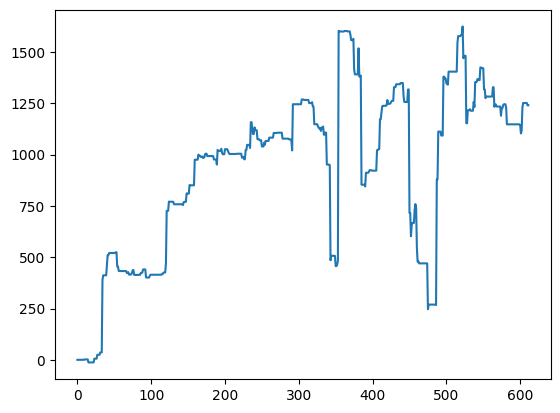

In [30]:
cumulative_returns = np.cumsum(returns)
plt.plot(cumulative_returns)
plt.savefig('/Users/vedantgupta/Documents/project /summer project(finance)/Pair-Trading--ML-TI-/Plots/Sensex Without Clustering  Weekly MACD+RSI.png')
plt.show()

## Strat-2 RSI

In [31]:
def get_returns1(master_macd, master_rsi, prices):
    returns = []
    intrade = []
    tradesheet = pd.DataFrame(columns=['Date','Buy Stock','Sell Stock','Buy Price','Sell Price','Buy Quantity','Sell Quantity','Profit'])
    i = 0
    while(i<len(prices)) :
        buy = 0
        buy_rsi = 100.0
        sell = 0
        sell_rsi = 0.0
        for j in range(1,len(prices.columns)):
            if(master_rsi.iloc[i,j]<30):
                if(master_rsi.iloc[i,j]<buy_rsi):
                    buy = j
                    buy_rsi = master_rsi.iloc[i,j]
            elif(master_rsi.iloc[i,j]>70):
                if(master_rsi.iloc[i,j]>sell_rsi):
                    sell = j
                    sell_rsi = master_rsi.iloc[i,j]

        if(len(intrade)==0) :
            returns.append(0)
            
        else :
            b1 = prices.iloc[intrade[0][0],intrade[0][1]]
            s1 = prices.iloc[intrade[0][0],intrade[0][3]]
            b2 = prices.iloc[i,intrade[0][1]]
            s2 = prices.iloc[i,intrade[0][3]]
            r = (((b2-b1))*intrade[0][2]) + ((s1-s2))
            row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[intrade[0][3]],'Sell Stock':prices.columns[intrade[0][1]],'Buy Price':s2,'Sell Price':b2,'Buy Quantity':1,'Sell Quantity':intrade[0][2],'Profit':r},index=[0])
            tradesheet = pd.concat([tradesheet,row],ignore_index=True)
            returns.append(r)
            intrade.clear()

        
        if(buy!=0 and sell!=0) :
            buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
            l = [i,buy,buy_quantity,sell]
            row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[buy],'Sell Stock':prices.columns[sell],'Buy Price':prices.iloc[i,buy],'Sell Price':prices.iloc[i,sell],'Buy Quantity':buy_quantity,'Sell Quantity':float(1),'Profit':0},index=[0])
            tradesheet = pd.concat([tradesheet,row],ignore_index=True)
            intrade.append(l)
        
        i = i+1

    return returns, intrade, tradesheet

In [32]:
returns1,intrade1, tradesheet1 = get_returns1(master_macd, master_rsi, prices)

/var/folders/90/5g2l2f2j191dmr85qjr8jrn40000gn/T/ipykernel_42146/2907237359.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tradesheet = pd.concat([tradesheet,row],ignore_index=True)


In [33]:
tradesheet1.to_csv('/Users/vedantgupta/Documents/project /summer project(finance)/Pair-Trading--ML-TI-/tradesheets/Sensex/Without Clustering/Weekly RSI Sensex.csv',index=False)
tradesheet1

,Date,Buy Stock,Sell Stock,Buy Price,Sell Price,Buy Quantity,Sell Quantity,Profit
0,2011-05-22,TATA IB Equity,NEST IB Equity,54.25,4178.90,77.030415,1.000000,0
1,2011-05-29,NEST IB Equity,TATA IB Equity,4012.05,52.46,1.000000,77.030415,28.965558
2,2011-06-05,SBIN IB Equity,APNT IB Equity,223.60,308.01,1.377504,1.000000,0
3,2011-06-12,APNT IB Equity,SBIN IB Equity,317.29,231.16,1.000000,1.377504,1.133934
4,2011-06-26,TTMT IB Equity,TTAN IB Equity,184.08,231.00,1.254889,1.000000,0
...,...,...,...,...,...,...,...,...
93,2020-03-08,BAF IB Equity,ITC IB Equity,4363.25,195.55,1.000000,23.661823,263.819421
94,2022-07-17,WPRO IB Equity,MM IB Equity,411.20,1165.05,2.833293,1.000000,0
95,2022-07-24,MM IB Equity,WPRO IB Equity,1163.05,404.75,1.000000,2.833293,-16.274739
96,2022-07-24,WPRO IB Equity,MM IB Equity,404.75,1163.05,2.873502,1.000000,0


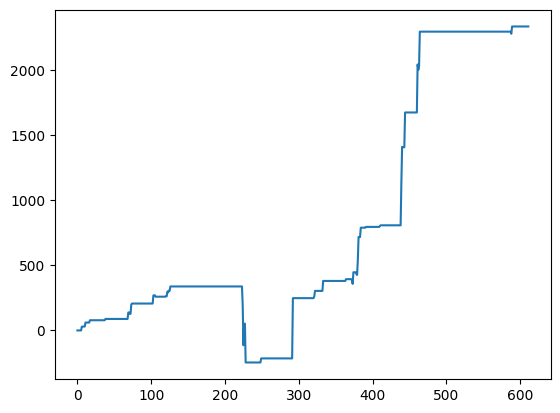

In [34]:
cumulative_returns = np.cumsum(returns1)
plt.plot(cumulative_returns)
plt.savefig('/Users/vedantgupta/Documents/project /summer project(finance)/Pair-Trading--ML-TI-/Plots/Sensex Without Clustering  Weekly RSI.png')
plt.show()